In [3]:
import pickle
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sksurv.preprocessing import OneHotEncoder as SurvOneHotEncoder
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.column import encode_categorical
from sksurv.column import standardize

import matplotlib.pyplot as plt


pd.set_option("display.max_rows", 500)

In [4]:
pickle_file = "data/COX_DATA_FULL_LIVING.pkl"

with open(pickle_file, "rb") as f:
    living = pickle.load(f)

living.drop(["DIAG_KI", "COD_KI"], axis=1, inplace=True)

pickle_file = "data/DATA_DECEASED.pkl"
with open(pickle_file, "rb") as f:
    deceased = pickle.load(f)

print("living: ", living.shape)
print("deceased: ", deceased.shape)

living:  (52420, 56)
deceased:  (117568, 19)


In [5]:
colors = [
    "#052759",
    "#a9d9e9",
    "#bbe3f1",
    "#ddf1f8",
    "#425f8c",
    "#063a89",
]

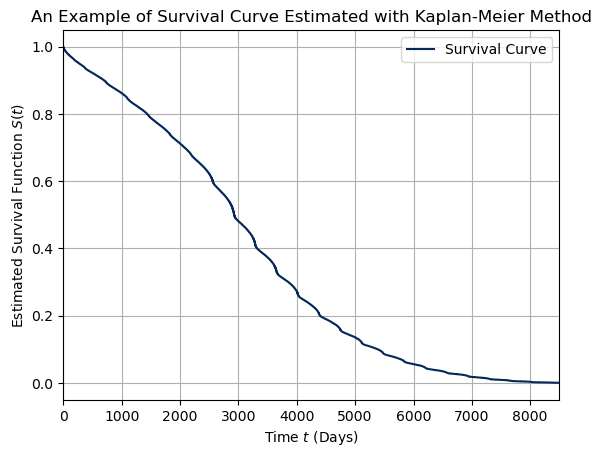

In [81]:
time_gen, surv_prob_gen = kaplan_meier_estimator(
    deceased["PSTATUS"].astype("bool"), deceased["PTIME"]
)
plt.step(
    time_gen,
    surv_prob_gen,
    where="post",
    label="Survival Curve",
    color=colors[0]
)
time_gen, surv_prob_gen = kaplan_meier_estimator(
    living["PSTATUS"].astype("bool"), living["PTIME"]
)

plt.title("An Example of Survival Curve Estimated with Kaplan-Meier Method")
plt.ylabel("Estimated Survival Function ${S}(t)$")
plt.xlabel("Time $t$ (Days)")
plt.grid(True)
plt.legend(loc="best")
plt.xlim(0,8500)
path = "../Thesis/Images/EDA/"
plt.savefig(path + "example-km.pdf", bbox_inches="tight")
plt.show()

# 3.1

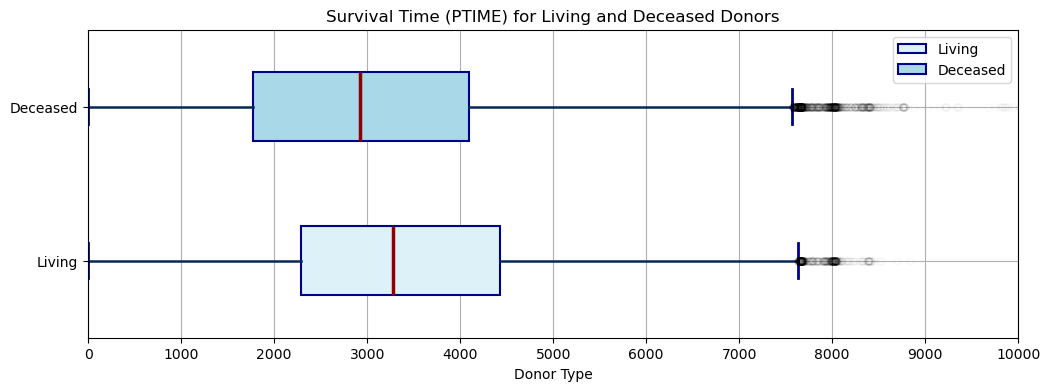

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.figure.set_size_inches(12, 4)
ax.set_xlim(0, 10000)
ax.set_xticks(np.linspace(0, 10000, 11))
living_box = ax.boxplot(
    living["PTIME"].astype("float"),
    positions=[1],
    widths=0.45,
    patch_artist=True,
    vert=0,
    boxprops=dict(facecolor="#ddf1f8", color="darkblue", lw=1.5),
    whiskerprops=dict(color="#052759", lw=1.8),
    capprops=dict(color="darkblue", lw=2),
    medianprops=dict(color="darkred", lw=2.5),
    flierprops=dict(markersize=5, alpha=0.025),
)
deceased_box = ax.boxplot(
    deceased["PTIME"].astype("float"),
    positions=[2],
    widths=0.45,
    patch_artist=True,
    vert=0,
    boxprops=dict(facecolor="#a9d9e9", color="darkblue", lw=1.5),
    whiskerprops=dict(color="#052759", lw=1.8),
    capprops=dict(color="darkblue", lw=2),
    medianprops=dict(color="darkred", lw=2.5),
    flierprops=dict(markersize=5, alpha=0.025),
)

ax.set_yticklabels(["Living", "Deceased"])
ax.set_xlabel("Donor Type")
ax.set_title("Survival Time (PTIME) for Living and Deceased Donors")

ax.legend([living_box["boxes"][0], deceased_box["boxes"][0]], ["Living", "Deceased"])

plt.grid(True)
path = "../Thesis/Images/EDA/"
plt.savefig(path + "survival-box.pdf", bbox_inches="tight")
plt.show()

In [7]:
quantiles_dc = deceased["PTIME"].astype("float").quantile([0.25, 0.5, 0.75, 0.90, 0.99])
quantiles_lv = living["PTIME"].astype("float").quantile([0.25, 0.5, 0.75, 0.90, 0.99])

quantiles_df = pd.DataFrame({
    'Deceased': quantiles_dc.values,
    'Living': quantiles_lv.values
}, index=['25q', 'median', '75q', '90q', '99q'])

quantiles_df.T

,25q,median,75q,90q,99q
Deceased,1770.00,2926.0,4091.0,5387.0,7397.33
Living,2287.75,3280.0,4426.0,5701.0,7623.00


# Figure 3.2


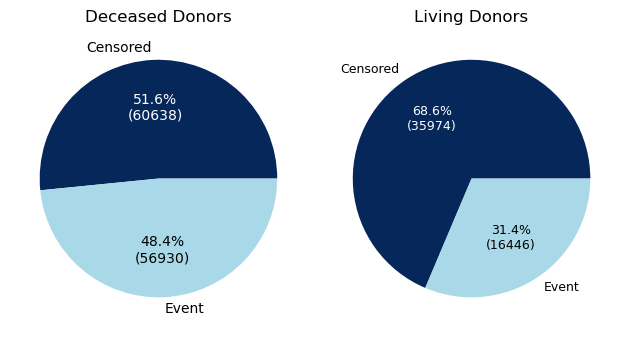

In [8]:
colors = ["#052759", "#a9d9e9"]


def custom_autopct(pct, allvalues):
    absolute = int(round(pct / 100.0 * sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


fig, (ax1, ax2) = plt.subplots(1, 2)

deceased_counts = deceased["PSTATUS"].value_counts()
wedges1, texts1, autotexts1 = ax1.pie(
    deceased_counts,
    labels=["Censored", "Event"],
    autopct=lambda pct: custom_autopct(pct, deceased_counts),
    colors=colors,
)
ax1.set_title("Deceased Donors")

for i, autotext in enumerate(autotexts1):
    if i == 0:
        autotext.set_color("white")
    else:
        autotext.set_color("black")

living_counts = living["PSTATUS"].value_counts()
wedges2, texts2, autotexts2 = ax2.pie(
    living_counts,
    labels=["Censored", "Event"],
    autopct=lambda pct: custom_autopct(pct, living_counts),
    colors=colors,
    textprops={"fontsize": 9},
)
ax2.set_title("Living Donors")

for i, autotext in enumerate(autotexts2):
    if i == 0:
        autotext.set_color("white")
    else:
        autotext.set_color("black")

path = "../Thesis/Images/EDA/"
plt.savefig(path + "censoring-pie.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

# 3.3 A

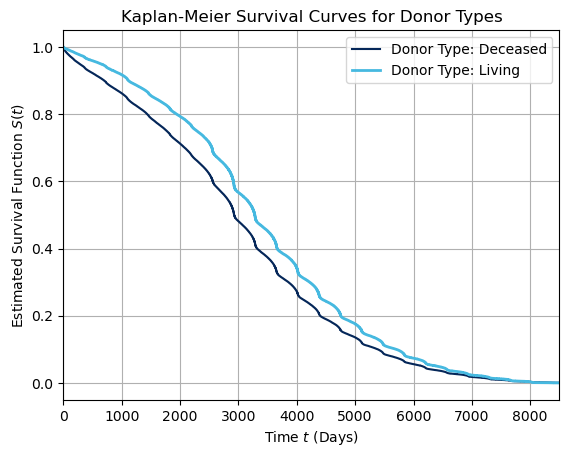

In [78]:
time_gen, surv_prob_gen = kaplan_meier_estimator(
    deceased["PSTATUS"].astype("bool"), deceased["PTIME"]
)
plt.step(
    time_gen,
    surv_prob_gen,
    where="post",
    label="Donor Type: Deceased",
    color=colors[0]
)
time_gen, surv_prob_gen = kaplan_meier_estimator(
    living["PSTATUS"].astype("bool"), living["PTIME"]
)
plt.step(
    time_gen,
    surv_prob_gen,
    where="post",
    label="Donor Type: Living",
    color="#46b9e0",
    linewidth=2
)
plt.title("Kaplan-Meier Survival Curves for Donor Types")
plt.ylabel("Estimated Survival Function ${S}(t)$")
plt.xlabel("Time $t$ (Days)")
plt.grid(True)
plt.legend(loc="best")
path = "../Thesis/Images/EDA/"
plt.xlim(0,8500)
plt.savefig(path + "donor-type-km.pdf", bbox_inches="tight")
plt.show()

# 3.3 B

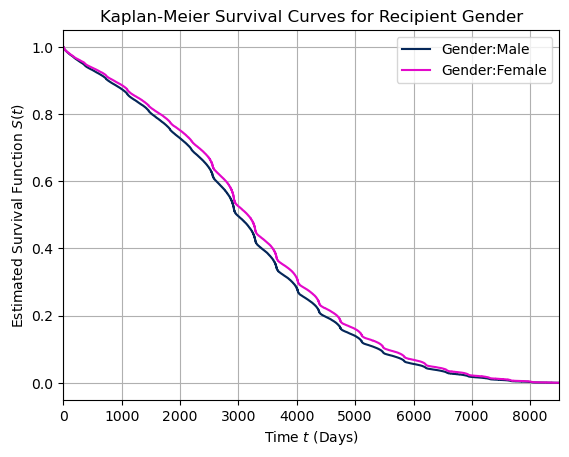

In [10]:
df1 = deceased[["PTIME", "PSTATUS", "GENDER"]]
df2 = living[["PTIME", "PSTATUS", "GENDER"]]
new_df = pd.concat([df1, df2], ignore_index=True)

for gender in new_df["GENDER"].unique():
    mask_gen = new_df["GENDER"] == gender
    time_gen, surv_prob_gen = kaplan_meier_estimator(
        new_df["PSTATUS"].astype("bool")[mask_gen], new_df["PTIME"][mask_gen]
    )
    plt.step(
        time_gen,
        surv_prob_gen,
        where="post",
        label="Gender:%s" % ("Male" if gender == "M" else "Female"),
        color=colors[0] if gender == "M" else "#e309ca",
    )

plt.title("Kaplan-Meier Survival Curves for Recipient Gender")
plt.ylabel("Estimated Survival Function ${S}(t)$")
plt.xlabel("Time $t$ (Days)")
plt.grid(True)
plt.legend(loc="best")
plt.xlim(0,8500)
path = "../Thesis/Images/EDA/"
plt.savefig(path + "gender-km.pdf", bbox_inches="tight")
plt.show()

# Figure 3.5

### 3.5 a)


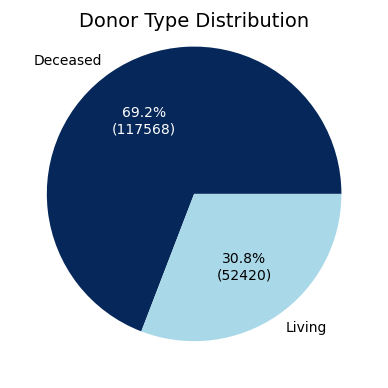

In [11]:
length_df1 = len(deceased)
length_df2 = len(living)

don_ty_lengths = [length_df1, length_df2]
labels = ["Deceased", "Living"]

plt.figure(figsize=(4, 4))
wedges, texts, autotexts = plt.pie(
    don_ty_lengths,
    labels=labels,
    autopct=lambda pct: custom_autopct(pct, don_ty_lengths),
    colors=colors,
)

for i, autotext in enumerate(autotexts):
    if i == 0:
        autotext.set_color("white")

path = "../Thesis/Images/EDA/"
plt.title("Donor Type Distribution", fontsize=14, y=0.93)
plt.savefig(path + "don-type-pie.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

### 3.5 b


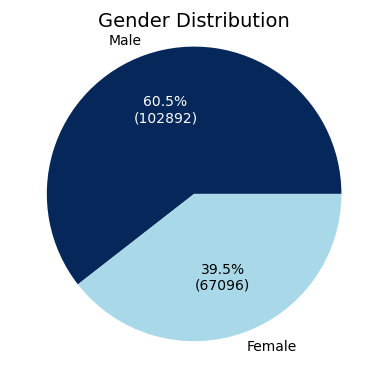

In [12]:
gender = deceased["GENDER"].value_counts() + living["GENDER"].value_counts()

plt.figure(figsize=(4, 4))
wedges, texts, autotexts = plt.pie(
    gender,
    labels=["Male", "Female"],
    autopct=lambda pct: custom_autopct(pct, gender),
    colors=colors,
)

for i, autotext in enumerate(autotexts):
    if i == 0:
        autotext.set_color("white")

path = "../Thesis/Images/EDA/"
plt.title("Gender Distribution", fontsize=14, y=0.93)
plt.savefig(path + "gender-pie.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

# 3.6 A

In [13]:
living['ON_DIALYSIS'].value_counts()

Y    29932
N    22488
Name: ON_DIALYSIS, dtype: int64

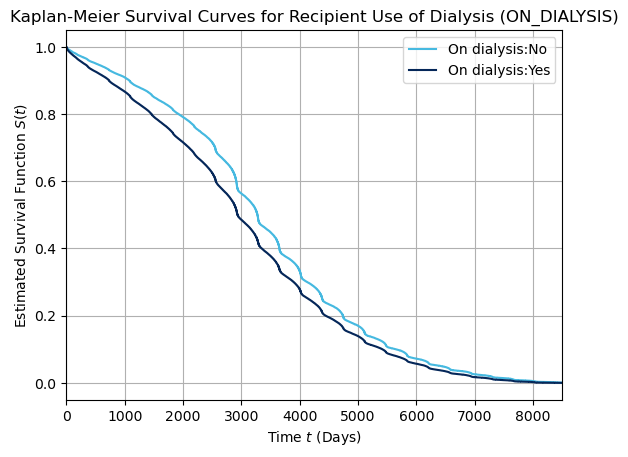

In [14]:
df1 = deceased[["PTIME", "PSTATUS", "ON_DIALYSIS"]]
df2 = living[["PTIME", "PSTATUS", "ON_DIALYSIS"]]
new_df = pd.concat([df1, df2], ignore_index=True)

new_df["ON_DIALYSIS"] = new_df["ON_DIALYSIS"].astype("str")

for dialysis in new_df["ON_DIALYSIS"].unique():
    mask_gen = new_df["ON_DIALYSIS"] == dialysis
    time_gen, surv_prob_gen = kaplan_meier_estimator(
        new_df["PSTATUS"].astype("bool")[mask_gen], new_df["PTIME"][mask_gen]
    )
    plt.step(
        time_gen,
        surv_prob_gen,
        where="post",
        label="On dialysis:%s" % ("Yes" if dialysis == "Y" else "No"),
        color=colors[0] if dialysis == "Y" else "#46b9e0",
    )

plt.title("Kaplan-Meier Survival Curves for Recipient Use of Dialysis (ON_DIALYSIS)")
plt.ylabel("Estimated Survival Function ${S}(t)$")
plt.xlabel("Time $t$ (Days)")
plt.grid(True)
plt.legend(loc="best")
plt.xlim(0,8500)
path = "../Thesis/Images/EDA/"
plt.savefig(path + "dialysis-km.pdf", bbox_inches="tight")
plt.show()

# 3.6 B

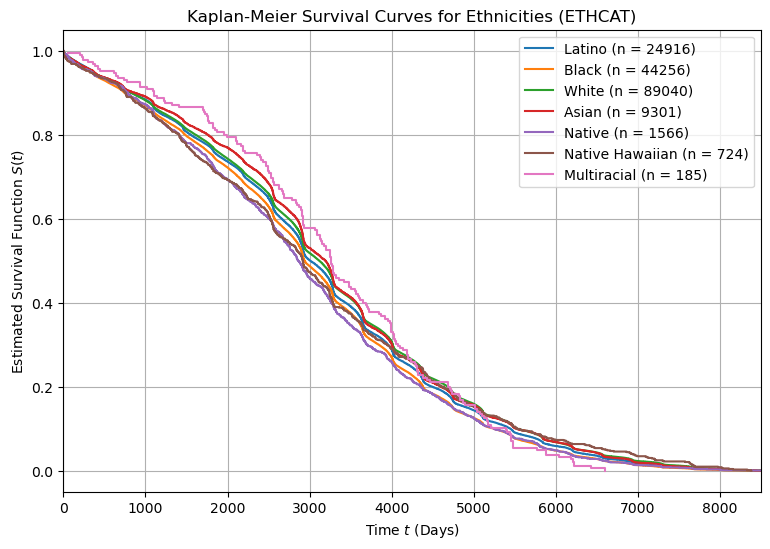

In [15]:
eth = {1: "White",
       2: "Black",
       4: "Latino",
       5: "Asian",
       6: "Native",
       7: "Native Hawaiian",
       9: "Multiracial"}
df1 = deceased[["PTIME", "PSTATUS", "ETHCAT"]]
df2 = living[["PTIME", "PSTATUS", "ETHCAT"]]
ethncat_df = pd.concat([df1, df2], ignore_index=True)

plt.figure(figsize=(9,6))

for value in ethncat_df["ETHCAT"].unique():
    mask = ethncat_df["ETHCAT"] == value
    time_cell, survival_prob_cell = kaplan_meier_estimator(ethncat_df["PSTATUS"].astype('bool')[mask],
                                                           ethncat_df["PTIME"][mask])
    plt.step(time_cell, survival_prob_cell, where="post",
             label="%s (n = %d)" % (eth[int(value)], mask.sum()))

plt.title("Kaplan-Meier Survival Curves for Ethnicities (ETHCAT)")
plt.ylabel("Estimated Survival Function ${S}(t)$")
plt.xlabel("Time $t$ (Days)")
plt.xlim(0,8500)
plt.grid(True)
plt.legend(loc="best")
path = "../Thesis/Images/EDA/"
plt.savefig(path + "eth-km.pdf", bbox_inches="tight")
plt.show()

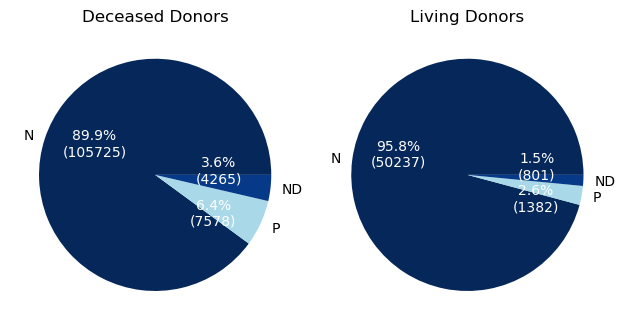

In [16]:
import matplotlib.pyplot as plt

colors = ["#052759", "#a9d9e9", "#063a89"]


def custom_autopct(pct, allvalues):
    absolute = int(round(pct / 100.0 * sum(allvalues)))
    return "{:.1f}%\n({:d})".format(pct, absolute)


fig, (ax1, ax2) = plt.subplots(1, 2)

deceased_counts = deceased["HCV_SEROSTATUS"].value_counts()
wedges1, texts1, autotexts1 = ax1.pie(
    deceased_counts,
    labels=deceased_counts.index,
    autopct=lambda pct: custom_autopct(pct, deceased_counts),
    colors=colors,
    pctdistance=0.55,
)
ax1.set_title("Deceased Donors")

for i, autotext in enumerate(autotexts1):
    if i in [0, 2]:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0], autotext.get_position()[1] + 0.1)
        )
    else:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0], autotext.get_position()[1] - 0.1)
        )

living_counts = living["HCV_SEROSTATUS"].value_counts()
wedges2, texts2, autotexts2 = ax2.pie(
    living_counts,
    labels=living_counts.index,
    autopct=lambda pct: custom_autopct(pct, living_counts),
    colors=colors,
)
ax2.set_title("Living Donors")

for i, autotext in enumerate(autotexts2):
    if i in [0, 2]:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0], autotext.get_position()[1] + 0.1)
        )
    else:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0], autotext.get_position()[1] - 0.1)
        )

plt.tight_layout()
plt.show()

# Deceased Donors


In [17]:
numeric_deceased = [
    "AGE",
    "BMI_CALC",
    "AGE_DON",
    "CREAT_TRR",
    "NPKID",
    "COLD_ISCH_KI",
]
categorical_deceased = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIAB",
    "HCV_SEROSTATUS",
    "DIABETES_DON",
]
categorical_living = [
    "ON_DIALYSIS",
    "PRE_TX_TXFUS",
    "GENDER",
    "ETHCAT",
    "DIAB",
    "HCV_SEROSTATUS",
    "ETHCAT_DON",
    "ABO_MAT",
    "HBV_CORE",
    "LIV_DON_TY",
]
numerical_living = [
    "KI_CREAT_PREOP",
    "SERUM_CREAT",
    "NPKID",
    "AGE",
    "HGT_CM_CALC",
    "BMI_DON_CALC",
    "AGE_DON",
]
desc = deceased[numeric_deceased].describe().T
table = desc.to_latex(
    caption="Descriptive Statistics for Numerical Variables in Deceased Donor Group",
    label="tab:desc_deceased",
)
print(table)

\begin{table}
\centering
\caption{Descriptive Statistics for Numerical Variables in Deceased Donor Group}
\label{tab:desc_deceased}
\begin{tabular}{lrrrrrrrr}
\toprule
{} &     count &       mean &        std &   min &    25\% &    50\% &   75\% &   max \\
\midrule
AGE          &  117568.0 &  51.883259 &  13.112097 &  18.0 &  43.00 &  53.00 &  62.0 &  90.0 \\
BMI\_CALC     &  117568.0 &  27.770096 &   5.419293 &  15.0 &  23.80 &  27.30 &  31.3 &  72.2 \\
AGE\_DON      &  117568.0 &  38.101618 &  16.595043 &   0.0 &  24.00 &  40.00 &  51.0 &  88.0 \\
CREAT\_TRR    &  117568.0 &   8.251785 &   3.508183 &   0.1 &   5.70 &   7.82 &  10.3 &  28.2 \\
NPKID        &  117568.0 &   0.122083 &   0.361227 &   0.0 &   0.00 &   0.00 &   0.0 &   5.0 \\
COLD\_ISCH\_KI &  117568.0 &  18.016163 &   8.981343 &   0.0 &  11.87 &  17.00 &  23.0 &  99.0 \\
\bottomrule
\end{tabular}
\end{table}



In [18]:
counts_on_dialysis = deceased["ON_DIALYSIS"].value_counts()
counts_pre_tx_txfus = deceased["PRE_TX_TXFUS"].value_counts()
counts_diabetes_don = deceased["DIABETES_DON"].value_counts()

# Calculate percentages
total_counts_on_dialysis = counts_on_dialysis.sum()
percentages_on_dialysis = (counts_on_dialysis / total_counts_on_dialysis * 100).round(2)

total_counts_pre_tx_txfus = counts_pre_tx_txfus.sum()
percentages_pre_tx_txfus = (counts_pre_tx_txfus / total_counts_pre_tx_txfus * 100).round(2)

total_counts_diabetes_don = counts_diabetes_don.sum()
percentages_diabetes_don = (counts_diabetes_don / total_counts_diabetes_don * 100).round(2)

# Format counts and percentages into strings
formatted_on_dialysis = counts_on_dialysis.astype(str) + ' (' + percentages_on_dialysis.astype(str) + '%)'
formatted_pre_tx_txfus = counts_pre_tx_txfus.astype(str) + ' (' + percentages_pre_tx_txfus.astype(str) + '%)'
formatted_diabetes_don = counts_diabetes_don.astype(str) + ' (' + percentages_diabetes_don.astype(str) + '%)'

# Create a DataFrame with formatted strings
yn_table = {
    "Value": ["Yes", "No"],
    "ON_DIALYSIS": formatted_on_dialysis,
    "PRE_TX_TXFUS": formatted_pre_tx_txfus,
    "DIABETES_DON": formatted_diabetes_don
}
yn_table = pd.DataFrame(yn_table)

# Convert DataFrame to LaTeX
yn_table_latex = yn_table.to_latex(
    caption="Frequency of Yes/No Variables in Deceased Donor Group",
    label="tab:yn_deceased",
    index=False
)

print(yn_table_latex)

\begin{table}
\centering
\caption{Frequency of Yes/No Variables in Deceased Donor Group}
\label{tab:yn_deceased}
\begin{tabular}{llll}
\toprule
Value &     ON\_DIALYSIS &    PRE\_TX\_TXFUS &     DIABETES\_DON \\
\midrule
  Yes &  25881 (22.01\%) &  88215 (75.03\%) &  109920 (93.49\%) \\
   No &  91687 (77.99\%) &  29353 (24.97\%) &     7648 (6.51\%) \\
\bottomrule
\end{tabular}
\end{table}



In [19]:
import json


def get_deceased_cat_feature_values(feature: str):
    deceased_file = "../Application/models/coxnet_deceased_desc.json"

    with open(deceased_file, "r") as f:
        dec_data = json.load(f)
    ethcat_dict = [x for x in dec_data["features"] if x["name"] == feature][0]
    values = ethcat_dict["possible_values"].values()
    return values


def get_living_cat_feature_values(feature: str):
    living_file = "../Application/models/coxnet_living_desc.json"

    with open(living_file, "r") as f:
        liv_data = json.load(f)
    ethcat_dict = [x for x in liv_data["features"] if x["name"] == feature][0]
    values = ethcat_dict["possible_values"].values()
    return values

# Figure 3.7


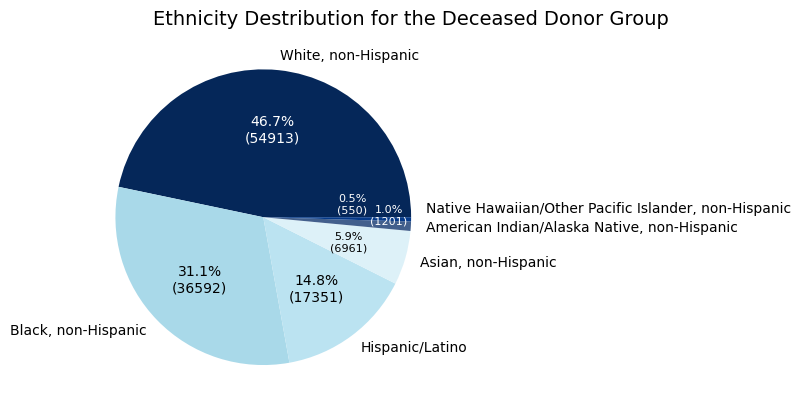

In [20]:
colors = [
    "#052759",
    "#a9d9e9",
    "#bbe3f1",
    "#ddf1f8",
    "#425f8c",
    "#063a89",
]
deceased_counts = deceased["ETHCAT"].value_counts()
ethcat_values = get_deceased_cat_feature_values("ETHCAT")
patches, texts, autotexts = plt.pie(
    deceased_counts,
    labels=list(ethcat_values)[:-1],
    autopct=lambda pct: custom_autopct(pct, deceased_counts),
    colors=colors,
)
texts[-1]._y = 0.06

total_texts = len(autotexts)

for i, autotext in enumerate(autotexts):
    if i == 0:
        autotext.set_color("white")
    elif i == total_texts - 1:
        autotext.set_color("white")
        autotext.set_fontsize(8)
        autotext.set_position(
            (autotext.get_position()[0], autotext.get_position()[1] + 0.1)
        )
    elif i == total_texts - 2:  # Second to last category
        autotext.set_color("white")
        autotext.set_fontsize(8)
        autotext.set_position(
            (autotext.get_position()[0] + 0.25, autotext.get_position()[1] + 0.05)
        )
    elif i == total_texts - 3:
        autotext.set_fontsize(8)
    elif i == total_texts - 4:
        autotext.set_fontsize(10)
    else:  # Other categories
        autotext.set_color("black")  # Assuming the default color for other categories
        if i == total_texts - 2:  # Second to last category
            autotext.set_position(
                (autotext.get_position()[0], autotext.get_position()[1] - 0.2)
            )

path = "../Thesis/Images/EDA/"
plt.title("Ethnicity Destribution for the Deceased Donor Group", fontsize=14, loc="center")
plt.gca().title.set_position([0.9, 1.05])
plt.savefig(path + "ethncat-deceased-pie.pdf", bbox_inches="tight")

plt.show()

THE SAME FOR THE LIVING? (3.7) no, in the living we have also ethncat_don. the table is preferrable there. Here it is better to use the pie chart.


# 3.8


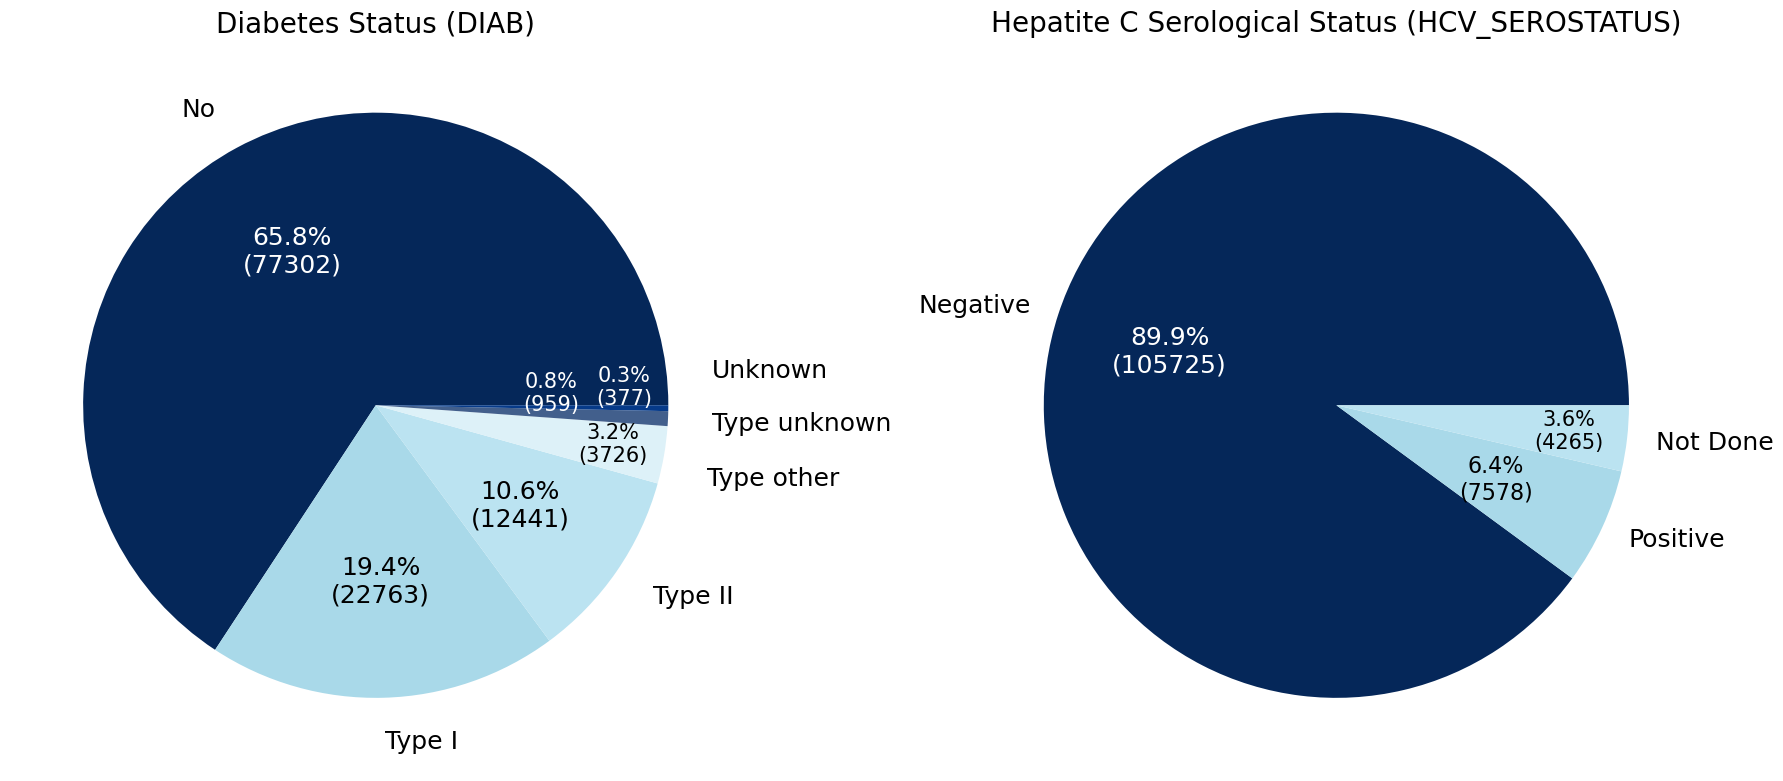

In [21]:
import matplotlib.pyplot as plt

fontsize = 18
title_fontsize = 20


fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(18, 9))

diab = deceased["DIAB"].value_counts()
patches2, texts2, autotexts2 = ax2.pie(
    diab,
    labels=get_deceased_cat_feature_values("DIAB"),
    autopct=lambda pct: custom_autopct(pct, diab),
    labeldistance=1.15,
    textprops={"fontsize": fontsize},
    colors=colors,
)
texts2[-1]._y = 0.12
texts2[-2]._y = -0.06
texts2[-3]._y = -0.25
ax2.set_title("Diabetes Status (DIAB)", fontsize=title_fontsize)

hcv = deceased["HCV_SEROSTATUS"].value_counts()
hcv_labels = list(get_deceased_cat_feature_values("HCV_SEROSTATUS"))[:-1]
patches3, texts3, autotexts3 = ax3.pie(
    hcv,
    labels=hcv_labels,
    autopct=lambda pct: custom_autopct(pct, hcv),
    textprops={"fontsize": fontsize},
    colors=colors,
)
ax3.set_title("Hepatite C Serological Status (HCV_SEROSTATUS)", fontsize=title_fontsize)

for i, autotext in enumerate(autotexts2):
    if i == 0:
        autotext.set_color("white")
    elif i == len(autotexts2) - 1:
        autotext.set_color("white")
        autotext.set_fontsize(15)
        autotext.set_position(
            (autotext.get_position()[0] + 0.25, autotext.get_position()[1] + 0.07)
        )
    elif i == len(autotexts2) - 2:
        autotext.set_color("white")
        autotext.set_fontsize(15)
        autotext.set_position(
            (autotext.get_position()[0], autotext.get_position()[1] + 0.07)
        )
    elif i == len(autotexts2) - 3:

        autotext.set_fontsize(15)
        autotext.set_position(
            (autotext.get_position()[0] + 0.22, autotext.get_position()[1] - 0.03)
        )
for i, autotext in enumerate(autotexts3):
    if i == 0:
        autotext.set_color("white")
    elif i == 1:
        autotext.set_fontsize(16)
        (autotext.get_position()[0] + 0.2, autotext.get_position()[1] - 0.01)
    elif i == len(autotexts3) - 1:

        autotext.set_fontsize(15)
        autotext.set_position(
            (autotext.get_position()[0] + 0.2, autotext.get_position()[1] - 0.02)
        )
    elif i == len(autotexts3) - 2:

        autotext.set_fontsize(15)
        autotext.set_position(
            (autotext.get_position()[0] + 0.2, autotext.get_position()[1] - 0.02)
        )

path = "../Thesis/Images/EDA/"
plt.savefig(path + "diab-hcv-deceased-pie.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [22]:
# deceased['DIAB'].value_counts().plot(kind="pie", autopct='%1.1f%%', textprops={'fontsize': 10}, figsize=(12, 12))

# Living Donors


In [23]:
desc_living = living[numerical_living].astype("float").describe().T
desc_living = desc_living.round(2)
table_living = desc_living.to_latex(
    caption="Descriptive Statistics for Numerical Variables in Living Donor Group",
    label="tab:desc_living",
)
# print(table_living)

In [68]:
counts_ethcat_don = living["ETHCAT_DON"].value_counts()
total_counts_ethcat_don = counts_ethcat_don.sum()
percentages_ethcat_don = (counts_ethcat_don / total_counts_ethcat_don * 100).round(2)
formatted_ethcat_don = counts_ethcat_don.astype(str) + ' (' + percentages_ethcat_don.astype(str) + '%)'

formatted_ethcat_don.index = formatted_ethcat_don.index.astype('float')
formatted_ethcat_don.index = formatted_ethcat_don.index.astype('int')
formatted_ethcat_don

1    35778 (68.25%)
4     7386 (14.09%)
2     6639 (12.67%)
5      1958 (3.74%)
6       291 (0.56%)
9       216 (0.41%)
7       152 (0.29%)
Name: ETHCAT_DON, dtype: object

In [60]:
type(formatted_ethcat_don)

pandas.core.series.Series

In [62]:
formatted_ethcat_don[0]

'35778 (68.25%)'

In [56]:
counts_ethcat = living["ETHCAT"].value_counts()
total_counts_ethcat = counts_ethcat.sum()
percentages_ethcat = (counts_ethcat / total_counts_ethcat * 100).round(2)
formatted_ethcat = counts_ethcat.astype(str) + ' (' + percentages_ethcat.astype(str) + '%)'
formatted_ethcat

1    34127 (65.1%)
2    7664 (14.62%)
4    7565 (14.43%)
5     2340 (4.46%)
6       365 (0.7%)
9      185 (0.35%)
7      174 (0.33%)
Name: ETHCAT, dtype: object

In [76]:
ethcat_values = get_living_cat_feature_values("ETHCAT")

counts_ethcat = living["ETHCAT"].value_counts()
total_counts_ethcat = counts_ethcat.sum()
percentages_ethcat = (counts_ethcat / total_counts_ethcat * 100).round(2)
formatted_ethcat = counts_ethcat.astype(str) + ' (' + percentages_ethcat.astype(str) + '%)'

counts_ethcat_don = living["ETHCAT_DON"].value_counts()
total_counts_ethcat_don = counts_ethcat_don.sum()
percentages_ethcat_don = (counts_ethcat_don / total_counts_ethcat_don * 100).round(2)
formatted_ethcat_don = counts_ethcat_don.astype(str) + ' (' + percentages_ethcat_don.astype(str) + '%)'
formatted_ethcat_don.index = formatted_ethcat_don.index.astype('float')
formatted_ethcat_don.index = formatted_ethcat_don.index.astype('int')

ethcat_table = {
    "Category": list(ethcat_values),
    # "ETHCAT": living["ETHCAT"].value_counts().values,
    "ETHCAT": formatted_ethcat,
    # "ETHCAT_DON": living["ETHCAT_DON"].value_counts().values,
    # "ETHCAT_DON": formatted_ethcat_don,
    
}

ethcat_table = pd.DataFrame(ethcat_table)
ethcat_table = ethcat_table.to_latex(
    caption="Frequency table for ETHCAT and ETHCAT_DON in Living Donor Group",
    label="tab:ethcat_living",
    index=False,
)
print(ethcat_table)

\begin{table}
\centering
\caption{Frequency table for ETHCAT and ETHCAT_DON in Living Donor Group}
\label{tab:ethcat_living}
\begin{tabular}{ll}
\toprule
                                          Category &         ETHCAT \\
\midrule
                               White, non-Hispanic &  34127 (65.1\%) \\
                               Black, non-Hispanic &  7664 (14.62\%) \\
                                   Hispanic/Latino &  7565 (14.43\%) \\
                               Asian, non-Hispanic &   2340 (4.46\%) \\
       American Indian/Alaska Native, non-Hispanic &     365 (0.7\%) \\
 Native Hawaiian/Other Pacific Islander, non-Hi... &    185 (0.35\%) \\
                         Multiracial, non-Hispanic &    174 (0.33\%) \\
\bottomrule
\end{tabular}
\end{table}



In [45]:
counts_on_dialysis = living["ON_DIALYSIS"].value_counts()
total_counts_on_dialysis = counts_on_dialysis.sum()
percentages_on_dialysis = (counts_on_dialysis / total_counts_on_dialysis * 100).round(2)

counts_pre_tx_txfus = living["PRE_TX_TXFUS"].value_counts()
total_counts_pre_tx_txfus = counts_pre_tx_txfus.sum()
percentages_pre_tx_txfus = (counts_pre_tx_txfus / total_counts_pre_tx_txfus * 100).round(2)

formatted_on_dialysis = counts_on_dialysis.astype(str) + ' (' + percentages_on_dialysis.astype(str) + '%)'
formatted_pre_tx_txfus = counts_pre_tx_txfus.astype(str) + ' (' + percentages_pre_tx_txfus.astype(str) + '%)'

yn_table = {
    "Value": ["Yes", "No"],
    "ON_DIALYSIS": formatted_on_dialysis,
    "PRE_TX_TXFUS": formatted_pre_tx_txfus,
}
yn_table = pd.DataFrame(yn_table)
yn_table_latex = yn_table.to_latex(
    caption="Frequency of Yes/No Variables in Living Donor Group",
    label="tab:yn_living",
    index=False
)

print(yn_table_latex)

\begin{table}
\centering
\caption{Frequency of Yes/No Variables in Living Donor Group}
\label{tab:yn_living}
\begin{tabular}{lll}
\toprule
Value &    ON\_DIALYSIS &    PRE\_TX\_TXFUS \\
\midrule
  Yes &  22488 (42.9\%) &  42388 (80.86\%) \\
   No &  29932 (57.1\%) &  10032 (19.14\%) \\
\bottomrule
\end{tabular}
\end{table}



In [47]:
counts_hcv = living["HCV_SEROSTATUS"].value_counts()
counts_hbv = living["HBV_CORE"].value_counts()
total_counts_hcv = counts_hcv.sum()
percentages_hcv = (counts_hcv / total_counts_hcv * 100).round(2)
total_counts_hbv = counts_hbv.sum()
percentages_hbv = (counts_hbv / total_counts_hbv * 100).round(2)
formatted_hcv = counts_hcv.astype(str) + ' (' + percentages_hcv.astype(str) + '%)'
formatted_hbv = counts_hbv.astype(str) + ' (' + percentages_hbv.astype(str) + '%)'
np_table = {
    "Value": ["N", "P", "ND"],
    "HCV_SEROSTATUS": formatted_hcv,
    "HBV_CORE": formatted_hbv,
}

np_table = pd.DataFrame(np_table)
np_table = np_table.to_latex(
    caption="Frequency of N/P Variables in Living Donor Group", label="tab:np_living"
)
print(np_table)

\begin{table}
\centering
\caption{Frequency of N/P Variables in Living Donor Group}
\label{tab:np_living}
\begin{tabular}{llll}
\toprule
{} & Value &  HCV\_SEROSTATUS &        HBV\_CORE \\
\midrule
N  &     N &  50237 (95.84\%) &  43276 (82.56\%) \\
ND &     P &     801 (1.53\%) &   6429 (12.26\%) \\
P  &    ND &    1382 (2.64\%) &    2715 (5.18\%) \\
\bottomrule
\end{tabular}
\end{table}



# Figure 3.9


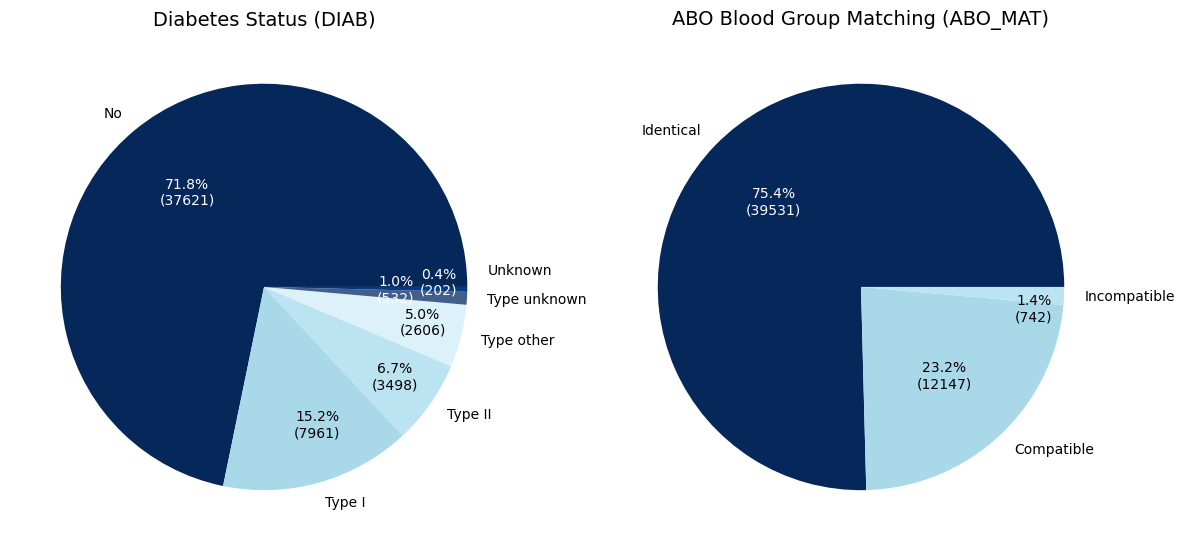

In [27]:
import matplotlib.pyplot as plt

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))

diab = living["DIAB"].value_counts()
patches, texts, autotexts1 = ax2.pie(
    diab,
    labels=get_living_cat_feature_values("DIAB"),
    autopct=lambda pct: custom_autopct(pct, diab),
    colors=colors,
)
texts[-1]._y = 0.08
ax2.set_title("Diabetes Status (DIAB)", fontsize=14)

for i, autotext in enumerate(autotexts1):
    if i == 0:
        autotext.set_color("white")
    if i == len(autotexts1) - 1:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0] + 0.26, autotext.get_position()[1] + 0.03)
        )
    if i == len(autotexts1) - 2:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0] + 0.05, autotext.get_position()[1] + 0.02)
        )
    if i == len(autotexts1) - 3:
        autotext.set_position(
            (autotext.get_position()[0] + 0.2, autotext.get_position()[1] - 0.029)
        )
    if i == len(autotexts1) - 4:
        autotext.set_position(
            (autotext.get_position()[0] + 0.15, autotext.get_position()[1] - 0.1)
        )
    if i == len(autotexts1) - 5:
        autotext.set_position(
            (autotext.get_position()[0] + 0.1, autotext.get_position()[1] - 0.1)
        )

abo = living["ABO_MAT"].value_counts()
patches, texts, autotexts2 = ax3.pie(
    abo,
    labels=get_living_cat_feature_values("ABO_MAT"),
    autopct=lambda pct: custom_autopct(pct, abo),
    colors=colors,
)
ax3.set_title("ABO Blood Group Matching (ABO_MAT)", fontsize=14)

for i, autotext in enumerate(autotexts2):
    if i == 0:
        autotext.set_color("white")
    elif i == 2:
        autotext.set_color("black")
        autotext.set_position(
            (autotext.get_position()[0] + 0.25, autotext.get_position()[1] - 0.08)
        )

path = "../Thesis/Images/EDA/"
plt.savefig(path + "diab-abo-living-pie.pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()

In [28]:
def get_living_donor_ty_values():
    living_file = "../Application/models/coxnet_living_desc.json"
    val_counts = living["LIV_DON_TY"].value_counts()

    with open(living_file, "r") as f:
        liv_data = json.load(f)
    ethcat_dict = [x for x in liv_data["features"] if x["name"] == "LIV_DON_TY"][0]
    possible_values = ethcat_dict["possible_values"]
    # print(ethcat_dict['possible_values'])
    values = [
        possible_values[poss_val]
        for poss_val in possible_values
        if poss_val in val_counts.index
    ]
    # print(values)
    return values

# 3.10


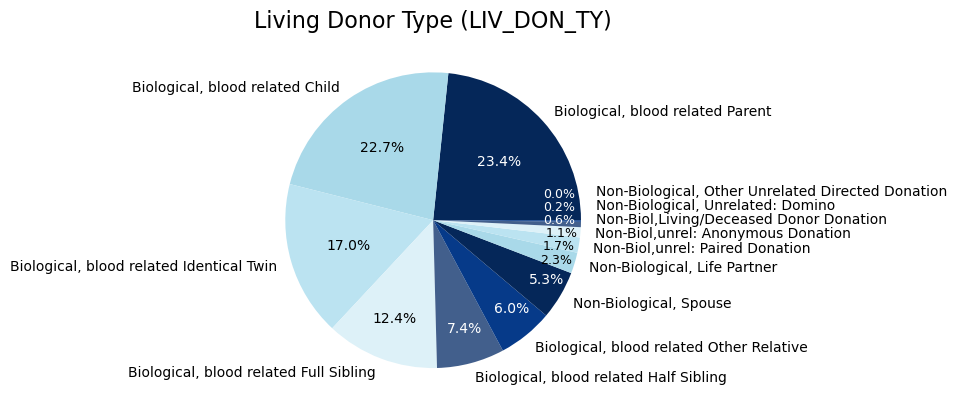

In [29]:
liv_don_ty = living["LIV_DON_TY"].value_counts()
labels = get_living_donor_ty_values()
patches, texts, autotexts = plt.pie(
    liv_don_ty, labels=labels, autopct="%1.1f%%", colors=colors
)
texts[-1]._y = 0.2
texts[-2]._y = 0.1
texts[-3]._y = 0.01
plt.title("Living Donor Type (LIV_DON_TY)", fontsize=16)

for i, autotext in enumerate(autotexts):
    if i == 0:
        autotext.set_color("white")
    if i == len(autotexts) - 1:
        autotext.set_color("white")
        autotext.set_fontsize(9)
        autotext.set_position(
            (autotext.get_position()[0] + 0.25, autotext.get_position()[1] + 0.18)
        )
    if i == len(autotexts) - 2:
        autotext.set_color("white")
        autotext.set_fontsize(9)
        autotext.set_position(
            (autotext.get_position()[0] + 0.25, autotext.get_position()[1] + 0.095)
        )
    if i == len(autotexts) - 3:
        autotext.set_color("white")
        autotext.set_fontsize(9)
        autotext.set_position(
            (autotext.get_position()[0] + 0.25, autotext.get_position()[1] + 0.02)
        )
    if i == len(autotexts) - 4:
        autotext.set_fontsize(9)
        autotext.set_position(
            (autotext.get_position()[0] + 0.27, autotext.get_position()[1] - 0.035)
        )
    if i == len(autotexts) - 5:
        autotext.set_fontsize(9)
        autotext.set_position(
            (autotext.get_position()[0] + 0.26, autotext.get_position()[1] - 0.07)
        )
    if i == len(autotexts) - 6:
        autotext.set_fontsize(9)
        autotext.set_position(
            (autotext.get_position()[0] + 0.255, autotext.get_position()[1] - 0.095)
        )
    if i == len(autotexts) - 7:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0] + 0.25, autotext.get_position()[1] - 0.095)
        )
    if i == len(autotexts) - 8:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0] + 0.15, autotext.get_position()[1] - 0.13)
        )
    if i == len(autotexts) - 9:
        autotext.set_color("white")
        autotext.set_position(
            (autotext.get_position()[0] + 0.06, autotext.get_position()[1] - 0.15)
        )
    if i == len(autotexts) - 10:
        autotext.set_position(
            (autotext.get_position()[0] - 0.05, autotext.get_position()[1] - 0.1)
        )

path = "../Thesis/Images/EDA/"
plt.savefig(path + "liv-don-ty-pie.pdf", bbox_inches="tight")

plt.show()

# Generate latex feature table


In [30]:
import json

categorical = categorical_deceased + categorical_living
numeric = numeric_deceased + numerical_living

def get_descriptions():
    deceased_file = "../Application/models/coxnet_deceased_desc.json"
    living_file = "../Application/models/coxnet_living_desc.json"
    file_paths = [deceased_file, living_file]
    
    name_desc = {}

    for file_path in file_paths:
        with open(file_path, "r") as f:
            desc_data = json.load(f)
            for feature in desc_data["features"]:
                if feature["name"] not in name_desc:
                    name_desc[feature["name"]] = feature["description"]
    return name_desc

name_desc = get_descriptions()

added_features = set()

unique_features = []
for feature in categorical + numeric:
    if feature not in added_features:
        unique_features.append(feature)
        added_features.add(feature)

feature_table = {
    "Feature": unique_features,
    "Description": [name_desc[feature] for feature in unique_features],
    "Type": ["Categorical" if feature in categorical else "Numerical" for feature in unique_features],
}

feature_table_df = pd.DataFrame(feature_table)
feature_table_latex = feature_table_df.to_latex(
    caption="Feature Table", label="tab:feature_table", index=False
)
print(feature_table_latex)

\begin{table}
\centering
\caption{Feature Table}
\label{tab:feature_table}
\begin{tabular}{lll}
\toprule
        Feature &                                        Description &         Type \\
\midrule
    ON\_DIALYSIS &    The recipient's pre-transplant dialysis status. &  Categorical \\
   PRE\_TX\_TXFUS &  The recipient's history of pre-transplant bloo... &  Categorical \\
         GENDER &                                   Recipient gender &  Categorical \\
         ETHCAT &                                Recipient ethnicity &  Categorical \\
           DIAB &  The presence or absence of diabetes in the rec... &  Categorical \\
 HCV\_SEROSTATUS &  The presence or absence of Hepatitis C in the ... &  Categorical \\
   DIABETES\_DON &  The presence or absence of diabetes in the donor. &  Categorical \\
     ETHCAT\_DON &                                    Donor ethnicity &  Categorical \\
        ABO\_MAT &                   Donor recipient blood type match &  Categorical \\
       HB